## Import libraries

In [98]:
import pandas as panda
import numpy as np
import matplotlib.pyplot as plt
from math import ceil

from sklearn import linear_model
from sklearn.model_selection import train_test_split

from sklearn.datasets import make_blobs
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, plot_confusion_matrix, confusion_matrix

from sklearn.decomposition import PCA
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.preprocessing import StandardScaler, normalize, MinMaxScaler

USE_SCALER_OPTIMIZATION = True
USE_MODEL_PARAMS_OPTIMIZATION = True
CALCULATE_MODEL_PARAMS_OPTIMIZATION = False


In [99]:
panda.set_option("display.max_columns", 57)

columns = []
with open("../data/columns.txt", "r") as doc:
    lines = doc.readlines()
    for line in lines:
        columns.append(line.split(":")[0])

In [100]:
df2 = panda.read_csv("../data/spambase.data", header=None)

## Data preprocessing. Training and test set

In [101]:
Y = df2[np.shape(df2)[1]-1] # class column
X = df2.drop([np.shape(df2)[1]-1], axis = 1) # remove class column

In [102]:
from tabulate import tabulate
if USE_SCALER_OPTIMIZATION:
    scaler = StandardScaler()
    X = panda.DataFrame(scaler.fit_transform(X))

In [103]:
# x = panda.DataFrame(normalize(x_original)) # Normalization worsen the quality of data

## Cross validation

In [104]:
CV = 3
if USE_MODEL_PARAMS_OPTIMIZATION:
    KNN_BEST_PARAMS = {'n_neighbors': 14, 'weights': 'distance'} 
    DT_BEST_PARAMS = {'criterion': 'gini', 'max_depth': 10, 'splitter': 'best'}
    SVC_BEST_PARAMS = {'kernel': 'rbf'}
else:
    KNN_BEST_PARAMS = {} 
    DT_BEST_PARAMS = {}
    SVC_BEST_PARAMS = {}

In [105]:
if CALCULATE_MODEL_PARAMS_OPTIMIZATION:
    cross_validate_model = KNeighborsClassifier()
    gscv = GridSearchCV(cross_validate_model, {'n_neighbors': np.arange(1, 25), 'weights': ['uniform', 'distance']}, cv=CV)
    gscv.fit(X, Y)
    KNN_BEST_PARAMS = gscv.best_params_.copy()


In [106]:
if CALCULATE_MODEL_PARAMS_OPTIMIZATION:
    cross_validate_model = DecisionTreeClassifier()
    gscv = GridSearchCV(cross_validate_model, {"criterion": ["gini", "entropy"], "splitter": ["best", "random"], "max_depth": np.arange(1,100)}, cv=CV)
    gscv.fit(X, Y)
    print(gscv.best_params_, gscv.best_score_)
    DT_BEST_PARAMS = gscv.best_params_.copy()


In [107]:
if CALCULATE_MODEL_PARAMS_OPTIMIZATION:
    cross_validate_model = SVC()
    gscv = GridSearchCV(cross_validate_model, {"kernel": ["linear", "poly","rbf", "sigmoid"]}, cv=CV)
    gscv.fit(X, Y)
    SVC_BEST_PARAMS = gscv.best_params_.copy()



In [108]:

cross_validate_model = BernoulliNB()
gscv = GridSearchCV(cross_validate_model, {}, cv=CV)
gscv.fit(X, Y)
SVC_BEST_PARAMS = gscv.best_params_.copy()

In [109]:
x_train, x_test, y_train, y_test = train_test_split(X,Y, random_state=69, train_size=0.66)

## Initialize models

In [110]:
MODELS = []
# MODELS.append(("Logistig Regression", LogisticRegression(max_iter=10000)))
MODELS.append(("K Nearest Neighbour", KNeighborsClassifier(**KNN_BEST_PARAMS)))
MODELS.append(("Decision Tree Classifier", DecisionTreeClassifier(**DT_BEST_PARAMS)))
# MODELS.append(("Bayes", BernoulliNB()))
#MODELS.append(("SVC", SVC()))
MODELS.append(("Support Vector Classification", SVC(**SVC_BEST_PARAMS)))
# MODELS.append(("Stochastic Gradient Descent", SGDClassifier()))
# MODELS.append(("Linear Discriminant Analysis", LinearDiscriminantAnalysis()))
# MODELS.append(("Gradient Boosting Classification ", GradientBoostingClassifier()))
# MODELS.append(("Random Forest Classification", RandomForestClassifier()))

In [111]:
def get_stats(y_predicted):
    accuracy = accuracy_score(y_test, y_predicted)
    precision = precision_score(y_test, y_predicted)
    recall = recall_score(y_test, y_predicted)
    f1 = f1_score(y_test, y_predicted)
    roc = roc_auc_score(y_test, y_predicted)

    y_true = np.copy(y_test) 
    y_pred = np.copy(y_predicted)
    target_names = ['class 0', 'class 1']

    cm = confusion_matrix(y_true, y_pred)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    accuracy_per_class = cm.diagonal()

    return [accuracy, *accuracy_per_class, precision,recall,f1,roc]


### Fit train data in model and predict

In [112]:
column_names = ["Model","Accuracy", "Acc spam", "Acc non spam", "Precision","Recall","F1-Score","AUC"]
results = []
for name, model in MODELS:
    model.fit(X=x_train, y=y_train)
    y_predicted = model.predict(x_test)
    results.append([name, *get_stats(y_predicted)])

## Create dataframe and sort

In [113]:
res = panda.DataFrame(results, columns=column_names)
res = res.sort_values(by="F1-Score", ascending=False)
res 
#0.848562	0.867173	0.732372	0.794092	0.828991
#0.911182	0.911715	0.860577	0.885408	0.902658 entropy

,Model,Accuracy,Acc spam,Acc non spam,Precision,Recall,F1-Score,AUC
2,Support Vector Classification,0.916933,0.957492,0.855769,0.930314,0.855769,0.891486,0.906631
1,Decision Tree Classifier,0.907987,0.926674,0.879808,0.888350,0.879808,0.884058,0.903241
0,K Nearest Neighbour,0.891374,0.929862,0.833333,0.887372,0.833333,0.859504,0.881598


### Sort the initial models by precision

In [114]:
diz = {v: i for i, v in enumerate(list(res["Model"]))}
SORTED_MODELS = sorted(MODELS, key = lambda x: diz[x[0]])

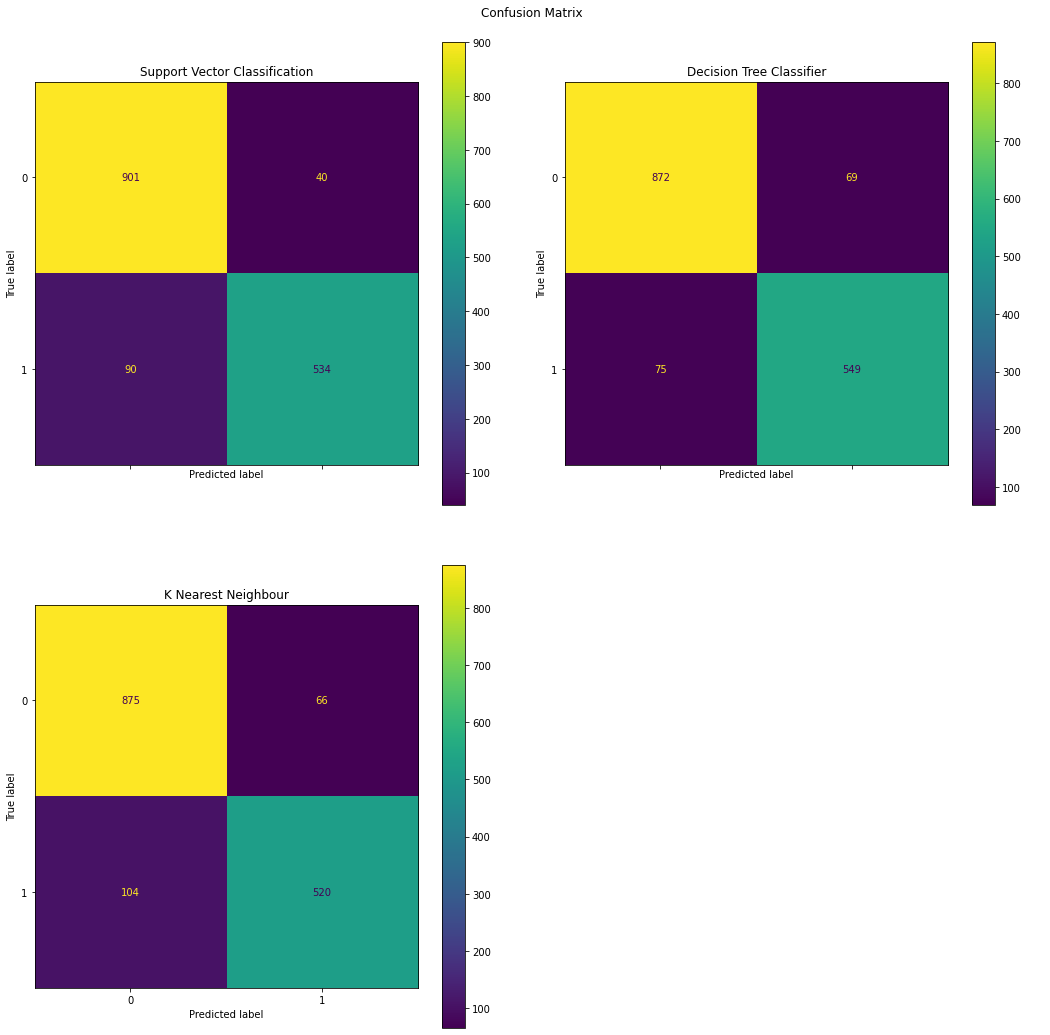

In [115]:
items_per_row = 2
fig, axs = plt.subplots(ceil(len(SORTED_MODELS)/items_per_row), items_per_row, sharex=True, figsize=(15,15))
fig.suptitle('Confusion Matrix')
fig.tight_layout(pad=2.0, h_pad=5.0)

for i, (name, model) in enumerate(SORTED_MODELS):
    y,x = i // items_per_row, i % items_per_row
    plot_confusion_matrix(model, x_test, y_test, ax=axs[y,x])
    axs[y,x].set_title(name)

for i in range(len(SORTED_MODELS),ceil(len(SORTED_MODELS)/items_per_row) * items_per_row):
    y,x = i // items_per_row, i % items_per_row
    axs[y,x].axis("off")


In [116]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.model_selection import cross_val_score
from numpy import mean, std
# # evaluate bagging algorithm for classification
# model = BaggingClassifier(base_estimator=RandomForestClassifier())
# # evaluate the model
# cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=10, random_state=69)

# n_scores = cross_val_score(model, X, Y, scoring='f1', cv=cv, n_jobs=-1, error_score='raise')
# print(n_scores)
# # report performance
# print('F1-score: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

[Text(0.5, 1.0, 'Decision tree'), Text(0, 0.5, 'F1-Score')]

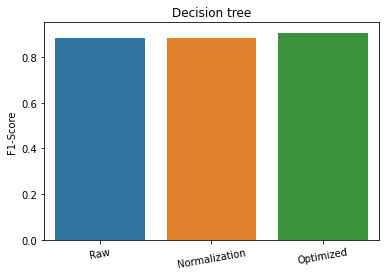

In [117]:
import seaborn as sns
plt.xticks(rotation=10)
sns.barplot(x=["Raw", "Normalization", "Optimized"],
        y=[0.885593,0.883159, 0.9061]).set(title="Decision tree",ylabel="F1-Score")

[Text(0.5, 1.0, 'KNN'), Text(0, 0.5, 'F1-Score')]

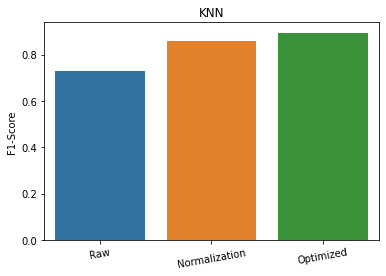

In [118]:
plt.xticks(rotation=10)
sns.barplot(x=["Raw", "Normalization", "Optimized"],
        y=[0.72958,0.8595, 0.893617]).set(title="KNN",ylabel="F1-Score")

[Text(0.5, 1.0, 'SVC'), Text(0, 0.5, 'F1-Score')]

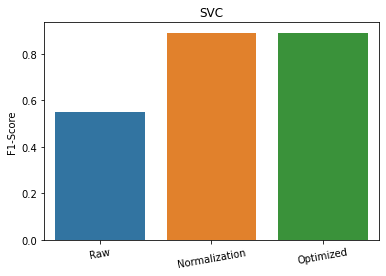

In [119]:
plt.xticks(rotation=10)
sns.barplot(x=["Raw", "Normalization", "Optimized"],
        y=[0.5520,0.891, 0.891]).set(title="SVC",ylabel="F1-Score")